In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import numpy.ma as ma
from matplotlib import gridspec

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/archie/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# import mitrate data

argo = pd.read_csv('../data/argo/7546KUROSHIOQC.txt', sep = ',')
argo2 = pd.read_csv('../data/argo/7674KUROSHIOQC.txt', sep = ',')

argo = argo.append(argo2,ignore_index=True)

month = []
for n in range(len(argo)):
    month.append(np.int(str(argo['Date/GMT'][n]).split('/')[0].lstrip('0   ')))

argo['MONTH'] = month


argo = argo[(argo['LON']>130) & (argo['LON']<170) & (argo['LAT']>30) & (argo['LAT']<45) & (argo['MONTH']>3) & (argo['MONTH']<11)]
print len(pd.unique(argo['Days since 1/1/1900']))

print len(argo)
print argo.columns

203
12179
Index([u'Date/GMT', u'Days since 1/1/1900', u'NITRATE[UMOL/KG]', u'DEPTH[M]',
       u'PRESSURE[DBAR]', u'MON/DAY/YR', u'SALINITY[PSS]', u'TEMPERATURE[C]',
       u'SIGMA_THETA[KG/M^3]', u'OXYGEN[UMOL/KG]', u'OXYGENSAT[%]', u'LON',
       u'LAT', u'MONTH'],
      dtype='object')


In [3]:
# read in JMA nutrient data

jma = pd.read_csv('../data/jma_nitrate.csv',sep=',')
jma['depth'] = jma['depth']*-1
jma = jma[(jma['lon']>140)& (jma['depth']>-150) & (jma['month']>3) & (jma['month']<11)]

print 'JMA profiles in dataset', len(pd.unique(jma['profile']))

argo = argo.rename(columns={'NITRATE[UMOL/KG]':'nitrate', 'DEPTH[M]':'depth', 'SALINITY[PSS]':'sal', 'SIGMA_THETA[KG/M^3]':'density', 'MONTH':'month', 'LAT':'lat','LON':'lon'})                       
allnuts = jma.append(argo[['nitrate','depth','lat','lon','density','month']] )

print len(allnuts), len(jma), len(argo)

JMA profiles in dataset 351
14360 2181 12179


In [4]:
# bin the nitrate data into sigma vs latitude bins

subset = allnuts[(allnuts['depth']>-150) & (allnuts['month']>3) & (allnuts['month']<11)] 

dy = 0.125
dx = 1./3

ybin = np.arange(21., 27., dy)
xbin = np.arange(30., 45., dx)

xgrid, ygrid = np.meshgrid(xbin, ybin, sparse=False, indexing='ij')

binned = np.empty([len(xbin), len(ybin)])
numobs = np.empty([len(xbin), len(ybin)])
binnedstd = np.empty([len(xbin), len(ybin)])
fvar = 'nitrate'

for i in range(len(xbin)):
    lat = xbin[i]
    for j in range(len(ybin)):
        sig = ybin[j]

        nn = len(subset.loc[((subset['lat']>lat-dx/2) & (subset['lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)

        if nn > 0:
            binned[i,j] = np.nanmean(subset.loc[((subset['lat']>lat-dx/2) & (subset['lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
            binnedstd[i,j] = np.nanstd(subset.loc[((subset['lat']>lat-dx/2) & (subset['lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
            numobs[i,j] = nn
        else:
            binned[i,j] = np.nan
            binnedstd[i,j] = np.nan
            numobs[i,j] = 0


/Users/archie/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


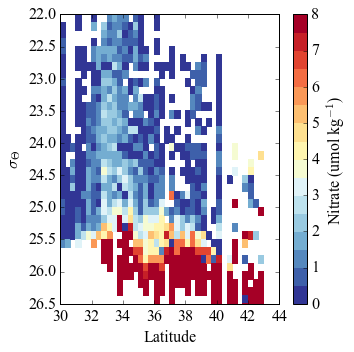

In [5]:
fig1 = plt.figure(1, figsize=(5,5), dpi = 300)
#plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 8, lw=0, alpha = 0.75)

palette = plt.get_cmap('RdYlBu_r', 16)

binned = ma.masked_where(np.isnan(binned), binned)
binnedstd = ma.masked_where(np.isnan(binnedstd), binnedstd)

plt.pcolor(xgrid, ygrid, binned, vmin = 0, vmax = 8, lw=0, cmap = palette)
# print len(pd.unique(subset['Days since 1/1/1900']))

#plt.contour()
cb = plt.colorbar(ticks = range(0, 9))
cb.set_label('Nitrate (umol kg$^{-1}$)', fontsize = 16)
#cb.set_label('Nitrate C.V.', fontsize = 20)
plt.gca().invert_yaxis()
plt.axis([ 30,44, 26.5, 22.0])

#plt.axhline(23.5, color='grey', lw=2)
#plt.axhline(25, color='grey', lw=2) 

#plt.axvline(32.66, color='grey', lw=2)
#plt.axvline(34.66, color='grey', lw=2) 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 16)
plt.xlabel('Latitude', fontsize = 16)
plt.tick_params(labelsize=16)
cb.ax.tick_params(labelsize=16)

plt.show()

#fig1.savefig('../figures/kuro_argo_no3_binned.png', dpi=300)

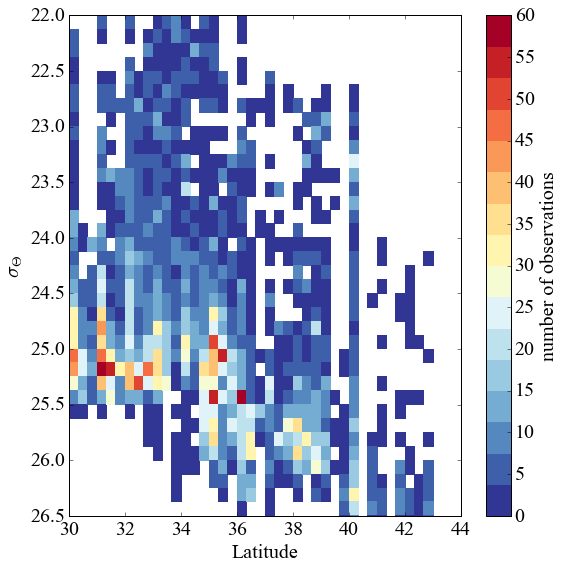

In [6]:
fig1 = plt.figure(1, figsize=(8,8))
#plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 8, lw=0, alpha = 0.75)

palette = plt.get_cmap('RdYlBu_r', 16)

numobs = ma.masked_where(np.isnan(binned), numobs)

plt.pcolor(xgrid, ygrid, numobs, vmin = 0, vmax = 60, lw=0, cmap = palette)
# print len(pd.unique(subset['Days since 1/1/1900']))

#plt.contour()
cb = plt.colorbar(ticks = range(0, 61,5))
cb.set_label('number of observations', fontsize = 20)
plt.gca().invert_yaxis()
plt.axis([ 30,44, 26.5, 22.0])

#plt.axhline(23.5, color='grey', lw=2)
#plt.axhline(25, color='grey', lw=2) 

#plt.axvline(32.66, color='grey', lw=2)
#plt.axvline(34.66, color='grey', lw=2) 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 20)
plt.xlabel('Latitude', fontsize = 20)
plt.tick_params(labelsize=20)
cb.ax.tick_params(labelsize=20)

plt.show()

#fig1.savefig('../figures/kuro_argo_no3_binned.png', bbox_inches='tight', dpi=300)

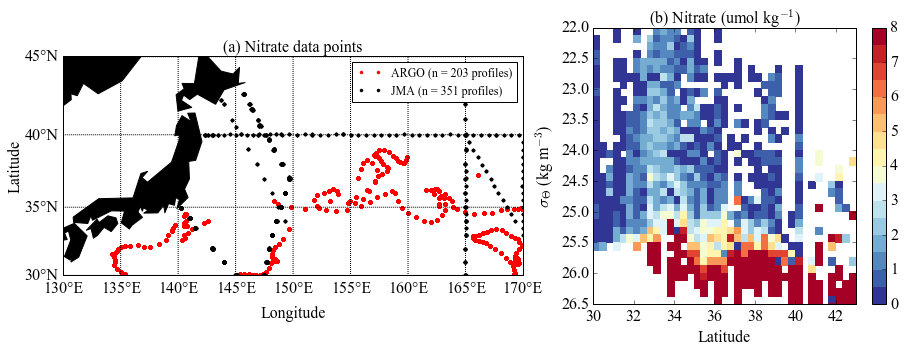

In [9]:
days = pd.unique(argo['Days since 1/1/1900'])

fig1 = plt.figure(figsize=(13, 5))
palette = plt.get_cmap('RdYlBu_r', 16)


gs = gridspec.GridSpec(1, 2, width_ratios=[1.75, 1.25]) 
ax1 = plt.subplot(gs[0])

m = Basemap(projection='merc',llcrnrlat=30,urcrnrlat=45.05,\
            llcrnrlon=130,urcrnrlon=170,lat_ts=0,resolution='c', ax = ax1)

m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='black',lake_color='white')

for d in days:
    subsetd = argo[argo['Days since 1/1/1900']==d]
    x, y = m(subsetd['lon'].values, subsetd['lat'].values)
    if d == days[0]:
        m.plot(x, y, '.', color = 'r', label = 'ARGO (n = 203 profiles)')
    else:
        m.plot(x, y, '.', color = 'r')
    
xx,yy = m(jma['lon'].values,jma['lat'].values)
m.plot(xx, yy, '.',color='k', label = 'JMA (n = 351 profiles)')
    
m.drawparallels(np.arange(-50,80,5),labels=[1,0,0,1], fontsize=16)
m.drawmeridians(np.arange(-180,180,5),labels=[0,0,0,1], fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xlabel('Longitude', fontsize = 16, labelpad = 30)
plt.ylabel('Latitude', fontsize = 16, labelpad = 40)

ax1.set_title('(a) Nitrate data points', fontsize = 16)
leg = ax1.legend(loc = 'upper right')
leg.get_frame().set_facecolor('white')

ax2 = plt.subplot(gs[1])

palette = plt.get_cmap('RdYlBu_r', 16)
cb = ax2.pcolor(xgrid, ygrid, binned, vmin = 0, vmax = 8, lw=0, cmap = palette)
#plt.contour()
cbar = fig1.colorbar(cb, ax=ax2, ticks = range(0, 9)) 
cbar.ax.tick_params(labelsize=16)

ax2.invert_yaxis()
ax2.set_xlim([30, 43])
ax2.set_ylim([26.5, 22.0])

#plt.axhline(23.5, color='grey', lw=2)
#plt.axhline(25, color='grey', lw=2) 

#plt.axvline(32.66, color='grey', lw=2)
#plt.axvline(34.66, color='grey', lw=2) 

ax2.set_ylabel(r'$\sigma_{\Theta}$ (kg m$^{-3}$)', fontsize = 16)
ax2.set_xlabel('Latitude', fontsize = 16)


ax2.set_title('(b) Nitrate (umol kg$^{-1}$)', fontsize = 16)
ax2.tick_params(labelsize=16)

plt.show()

fig1.savefig('../manuscript/Figure5.png', dpi=300)